<a href="https://colab.research.google.com/github/AsbjornPreuss/AppMLFinalProject/blob/main/CNN_on_Colab_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural network framework

In [2]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pandas as pd
sns.set_style("darkgrid")
from google.colab import drive
drive.mount('/content/drive')


# Keras documentation can be found on keras.io:
import keras
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Mounted at /content/drive


# Jens csv kode

In [3]:

def import_and_pad_csvs(folder_path):
    # List all CSV files in the given folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize an empty list to store the data arrays
    data_arrays = []

    # Iterate over the CSV files and read them into numpy arrays
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path).values
        data_arrays.append(data)

    # Find the maximum number of rows and columns among all CSV files
    max_rows = max(array.shape[0] for array in data_arrays)
    max_cols = max(array.shape[1] for array in data_arrays)

    # Find the index of the largest array (by number of elements)
    largest_array_index = max(range(len(data_arrays)), key=lambda i: data_arrays[i].shape[0] * data_arrays[i].shape[1])

    print(f"Index of the largest initial array: {largest_array_index}")

    # Initialize a list to store padded arrays
    padded_arrays = []

    # Pad each array with zeros to match the maximum size
    for array in data_arrays:
        padded_array = np.zeros((max_rows, max_cols)) + 4000
        padded_array[:array.shape[0], :array.shape[1]] = array
        padded_arrays.append(padded_array) #dimension to create the final array
    combined_array = np.stack(padded_arrays, axis=0)

    return combined_array

# Import Data

In [15]:
path = "drive/MyDrive/"
import tarfile
tar = tarfile.open(f"{path}clusters_colour_rotations.tar")
tar.extractall(f"{path}")

In [14]:
rm -r drive/MyDrive/clusters_colour_rotations

In [19]:
os.listdir(f"{path}clusters_colour_rotations/")
labels_raw = [np.load(f'{path}labels/'+x) for x in os.listdir(f'{path}labels/') if x.endswith('.npy')]
label = []
for value in labels_raw:
    label.append(value[1].tolist())
label = [item for sublist in label for item in sublist]
label = np.repeat(label, 8)

Index of the largest initial array: 487
(3144, 208, 209)
0


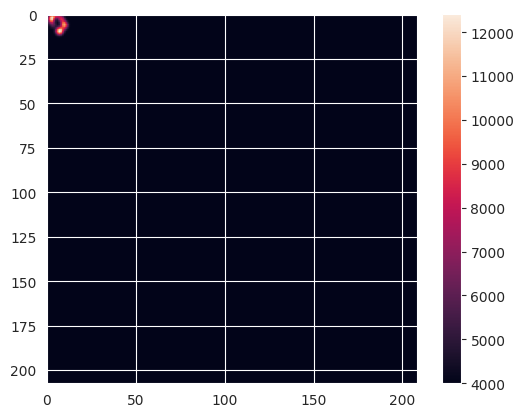

In [22]:
path = "drive/MyDrive/"
data_raw = import_and_pad_csvs(f'{path}clusters_colour_rotations/')
#print(len(label)*8)
#print(data_raw.shape)

# Remove all reading erros, multiple objects, and others.
data_raw = data_raw[(label != 4) & (label != 0)]
label = label[(label != 4) & (label != 0)] - 1

print(data_raw.shape)
# the data, split between train and testval sets
train_images, testval_images, train_labels, testval_labels = train_test_split(data_raw, label, test_size=0.3, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(testval_images, testval_labels, test_size=0.2, random_state=13052020)

plt.imshow(val_images[0])
plt.colorbar()
print(val_labels[0])

# Normelize Data

In [23]:
# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))
# Alternative: quantile normalization
# train_images = quantile_transform(train_images, output_distribution='normal', copy=True)
# val_images = quantile_transform(val_images, output_distribution='normal', copy=True)




# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 208, 209 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3 # number of classes
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
# test_images = quantile_transform(test_images, output_distribution='normal', copy=True)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Setup CNN

In [24]:
def compile_CNN_model(model_type=Sequential(), layer_types=[Conv2D, MaxPooling2D, Flatten, Dropout, Dense], hyperperams_list=np.zeros((7,3)), img_rows=28, img_cols=28, num_classes=10):
    model = model_type  # Network model type

    N_layers = len(layer_types)
    layers = np.array([])
    for i in range(layer_types):
        if layer_types[i] == 0:
            layers = np.append(layers, Conv2D)
            hyp_peram = {'filters': hyperperams_list[i, 0], 'kernel_size': hyperperams_list[i, 1], 'strides': hyperperams_list[i, 2], 'activation': 'relu', 'input_shape': (img_rows, img_cols, 1)}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 1:
            layers = np.append(layers, MaxPooling2D)
            hyp_peram = {'pool_size': hyperperams_list[i, 0], 'strides': hyperperams_list[i, 1]}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 2:
            layers = np.append(layers, Flatten)
            hyp_peram = {}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 3:
            layers = np.append(layers, Dropout)
            hyp_peram = {'rate': hyperperams_list[i, 0]}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 4:
            layers = np.append(layers, Dense)
            hyp_peram = {'units': hyperperams_list[i, 0], 'activation': 'relu'}


    for i in range(N_layers):
        model.add(layers[i](**layer_hyperperams[i]))


    # specify optimization strategy and metric used for monitoring during training
    model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

    return model



model = Sequential()  # Network type is Sequential

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 208, 209, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 104, 104, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 104, 104, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 52, 52, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 52, 52, 64)        0         
                                                                 
 flatten (Flatten)           (None, 173056)           

# Train CNN

In [25]:
# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=256,
                    epochs=100,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/100
9/9 [==============================] - 21s 1s/step - loss: 1.1786 - categorical_accuracy: 0.2514 - val_loss: 1.1494 - val_categorical_accuracy: 0.2358
Epoch 2/100
9/9 [==============================] - 3s 385ms/step - loss: 1.1526 - categorical_accuracy: 0.2891 - val_loss: 1.1314 - val_categorical_accuracy: 0.2861
Epoch 3/100
9/9 [==============================] - 3s 365ms/step - loss: 1.1396 - categorical_accuracy: 0.3145 - val_loss: 1.1168 - val_categorical_accuracy: 0.3311
Epoch 4/100
9/9 [==============================] - 3s 364ms/step - loss: 1.1216 - categorical_accuracy: 0.3400 - val_loss: 1.1050 - val_categorical_accuracy: 0.3656
Epoch 5/100
9/9 [==============================] - 3s 366ms/step - loss: 1.1155 - categorical_accuracy: 0.3668 - val_loss: 1.0947 - val_categorical_accuracy: 0.3894
Epoch 6/100
9/9 [==============================] - 3s 382ms/step - loss: 1.0976 - categorical_accuracy: 0.3782 - val_loss: 1.0864 - val_categorical_accuracy: 0.3881
Epoch 7/100


1/1 [==============================] - 0s 17ms/step
[[0.5332417  0.05793012 0.40882823]] [0. 1. 0.]


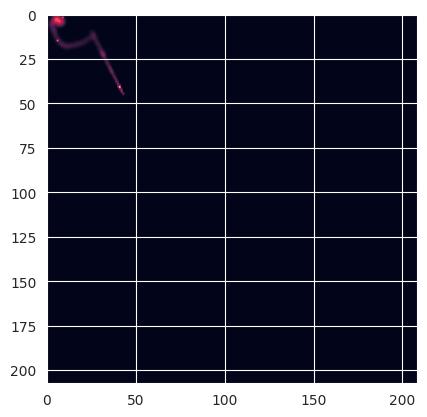

In [31]:
index = 4
plt.imshow(val_images[index])
print(model.predict(np.array([val_images[index]])), val_labels[index])

# Hyperperameter optimization

In [ ]:
import optuna


def objective(trial):
    layer_numbers = trial.suggest_int('layer_numbers', 1, 10)
    peram = {'model_type': Sequential(),
                'layer_types': [trail.sugeest_int('layer_types', 0, 4, layer_numbers) for i in range(layer_numbers)],
                'hyperperams_list': np.zeros((7,3)),
                'img_rows': 28,
                'img_cols': 28,
                'num_classes': 10
                }



def objective_example(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1),
        'objective': 'binary:logistic'
    }
    bst = XGBClassifier(**param)
    bst.fit(df_train_X_clf_final, df_train_Y_clf_final)
    preds = bst.predict_proba(df_valid_X_clf_final)
    log_log_clf_XGB = log_loss(df_valid_Y_clf_final, preds)
    return log_log_clf_XGB

study_example = optuna.create_study(direction='minimize')
study_example.optimize(objective_example, n_trials=20, show_progress_bar=True)